In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from IPython.display import display, clear_output
from scipy.optimize import fsolve, least_squares
from scipy.integrate import odeint, quad
from time import perf_counter
from scipy.interpolate import RectBivariateSpline
import pandas as pd
from numba import njit
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import importlib


Bad key text.latex.preview in file C:\Users\mcdon\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\mcdon\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\mcdon\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [36]:
##Parameters
import ParamsStakeholderOnBottom as p
importlib.reload(p)

#clean these up by making the names the same in both places and then from params import ntimes, tend, length, etc.
folder = p.folder #folder to save to
filename = p.filename
save = p.save

#simulation parameters
ntimes = p.n_times      #number of simulation time steps
tend = p.t_end        #end time in seconds
length = p.length   #domain length in meters. 
nelectrodes = 0   #number of electrodes
boundaryscale = p.boundary_scale #number of domain lengths extended for finite difference. 3 is one domain and another on each side
dt = p.dt       #timestep for physics

#target function parameters
target_type = p.target_type
v0 = p.v0                               #loiter velocity, m/s
xt = length/2                           #center of the circle
yt = length/2
rd = p.rd                             #desired loiter distance, m
pos = p.initial_position #initial positions of particles
nparticles = len(pos)                   #number of particles
nstakeholders = p.n_stakeholders         #number of stakeholders

#physical parameters
mu = p.mu                    #diffusiophoretic mobility of particle m^2/M s. Divide by 1000 to turn Liters to meters^3.
mue = p.mu_e                             #electrophoretic mobility of particles in Coulomb/Newton * m/s or m^2/V s 
mustakeholder = p.mu_stakeholder
muestakeholder = p.mu_e_stakeholder
epsilon = p.epsilon            #Dielectric constant of water in C^2/Nm^2 
D = p.D                          #diffusion coefficient of solute. This number is the self-diffusion coeff of water at 25 C.
Brown = p.Brown                            #Brownian motion. Set to 1 for on or 0 for off
T = p.T                              #Temperature in K
kb = p.kb                  #Boltzmann's constant
viscosity = p.viscosity                   #viscosity of water
radius = p.particle_radius                        #m, radius of colloidal particle
Dp = kb*T/(viscosity*6*np.pi*radius) #diffusion coefficient of colloidal particle

#controller parameters
nvision = p.n_vision         #prediction horizon
W1 = p.W_1             #weight for residuals in objective function
cutoffpercent = p.cutoff_percent #higher value will solve faster but be less accurate.
feedbackgain = p.feedback_gain  #gain for target function
ubefactor = p.ub_e_factor       #multiple of uemax to set upper bound at. 1 is normal for a single particle.
strength = p.strength #I think this would be the strength needed for the stakeholder to drag the other particle
print("strength",strength)

##Initialize arrays and define variables

#Find the locations of the evenly spaced probes
def setprobes(nprobes):
    x0 = np.zeros((nprobes,2))         #array for positions of chemical probes
    spacing = length/(nprobes/4 + 1)   
    count0,count1,count2,count3 = (0,0,0,0)
    for i in range(nprobes):           #space the probes evenly along each of the four sides
        if i%4 == 0: #left side
            x0[i,0]+= 0
            count0 += spacing
            x0[i,1]+= count0
        if i%4 == 1: #right side
            x0[i,0] += length
            count1 += spacing
            x0[i,1]+= count1
        if i%4 == 2: #bottom
            x0[i,1]+= 0
            count2 += spacing
            x0[i,0]+=count2       
        if i%4 == 3: #top
            x0[i,1]+= length
            count3 += spacing
            x0[i,0]+= count3
    return x0
x0e = setprobes(nelectrodes)


#some more setup stuff, generally don't change this
t = np.linspace(0.0,tend,ntimes) #time of simulation in seconds 
delta_t = t[1] - t[0]
tsteps = t.copy() + 0.0000001    #array for decision times. 0.0000001 lets us avoid dividing by zero. 
        

mode = "electric" #get rid of this

    
umax = 2*np.pi*D*length*v0/np.abs(mu)         #characteristic scale for chemical reaction
uemax = 2*np.pi*epsilon*length*v0/np.abs(muestakeholder) #characteristic scale for electric charge
#ube = ubefactor*uemax    #upper bound for electrode charge (or voltage? which one?) 

ube = ubefactor*v0
bnds = p.bnds

Lxy = boundaryscale*length    # simulation length
nxy     = 50*boundaryscale+1  # number of grid points in x and y directions
tFac    = 0.5                 # stability factor. Must be 0.5 or less
tau     = Lxy**2/D            # diffusive timescale based on the whole domain.
deltaxy = Lxy/(nxy-1)         # grid spacing in x and y directions
dtwant = tFac*deltaxy**2/D/4  # desired timestep size
if dt > dtwant:               #make sure to set this so that dt is a nice number smaller than dtwant
    print(dtwant)
    raise
dtratio = int(delta_t/dt)


###Functions

##target
if target_type == "circle":
    @njit #desired trajectory
    def targetpos(t):
        x = np.zeros(nparticles)
        y = np.zeros(nparticles)
        # x[0] = xt+rd*np.cos(v0*t/rd)
        # y[0] = yt+rd*np.sin(v0*t/rd)
        x[1] = xt+rd*np.cos(v0*t/rd) #fix this so it's not zero
        y[1] = yt+rd*np.sin(v0*t/rd)
        return np.vstack((x,y))

    @njit #velocity target (derivative of desired trajectory with a feedback correction)
    def targetfeedback(xs,t,xyought):
        k = feedbackgain
        x = xs[0]
        y = xs[1]
        xought = xyought[0]
        yought = xyought[1]
        dx = np.zeros(nparticles)
        dy = np.zeros(nparticles)
        # dx[0] = -v0*np.sin(v0*t/rd)-k*(x[0]-xought[0])
        # dy[0] = v0*np.cos(v0*t/rd) -k*(y[0]-yought[0])
        dx[1] = -v0*np.sin(v0*t/rd) -k*(x[1]-xought[1])
        dy[1] =v0*np.cos(v0*t/rd) -k*(y[1]-yought[1])
        return np.vstack((dx,dy))
elif target_type == "figure8":
    @njit #desired trajectory
    def targetpos(t):
        x = np.zeros(nparticles)
        y = np.zeros(nparticles)
        # x[0] = xt+rd*np.cos(v0*t/rd)
        # y[0] = yt+rd*np.sin(v0*t/rd)
        x[1] = xt+rd*np.sin(v0*t/rd)
        y[1] = yt+rd*np.sin(v0*t/rd)*np.cos(v0*t/rd)
        return np.vstack((x,y))

    @njit #velocity target (derivative of desired trajectory with a feedback correction)
    def targetfeedback(xs,t,xyought):
        k = feedbackgain
        x = xs[0]
        y = xs[1]
        xought = xyought[0]
        yought = xyought[1]
        dx = np.zeros(nparticles)
        dy = np.zeros(nparticles)
        # dx[0] = -v0*np.sin(v0*t/rd)-k*(x[0]-xought[0])
        # dy[0] = v0*np.cos(v0*t/rd) -k*(y[0]-yought[0])
        dx[1] = v0*np.cos(v0*t/rd) -k*(x[1]-xought[1])
        dy[1] = v0*(-np.sin(v0*t/rd)**2+np.cos(v0*t/rd)**2) -k*(y[1]-yought[1])
        return np.vstack((dx,dy))
else:
    raise Exception("target_type must be 'circle' or 'figure8'.")

##model

@njit #chemical kernel for a single step function
def f(t,tn,r,u_i,mu, D): 
    if t>tn:
        rsquared = r**2
        return -mu*u_i*np.exp(-rsquared/(4*D*(t-tn)))/(2*D*np.pi*rsquared) #note that this is missing the (x-x0), added in the ChemVeloc function.
    else:
        return 0

# find the cutoff time   
def findcutoffvalue(tdiff, delta_t):
    def derivfunc(t):
        if t <= delta_t:
            return 100000000 #big number, this is how I implement the Heaviside function.
        else:
            return np.exp(-tdiff/t)/t**2-np.exp(-tdiff/(t-delta_t))/(t-delta_t)**2
    maximum = fsolve(derivfunc,0.5*tdiff + 3/4*delta_t) 
    def func(t):
        return np.exp(-tdiff/t)-np.exp(-tdiff/(t-delta_t))
    def functosolve(t):
        return func(t) - cutoffpercent*func(maximum)
    answer = fsolve(functosolve,8*tdiff) #If it doesn't work, try a new guess value here
    return answer[0]
tdiff = length**2/4/D
tcutoff = findcutoffvalue(4*tdiff,delta_t)
if tcutoff < 0:
    raise     #If this raises an exception, try a new guess value above
ncutoffsteps = int(tcutoff/delta_t) #number of timesteps before cutoff. Note that this rounds down. Maybe you don't want that.

# @njit #finds electric contribution to vx and vy for all electrodes
# def ElectricVeloc(xy,x0, u,mue):
#     if nelectrodes == 0:
#         return np.array([0,0])
#     x = xy[0]
#     y = xy[1]
#     A = np.zeros((2,nelectrodes))
#     for j in range(nelectrodes): 
#         xij = x - x0e[j,0] #x distance from j'th electrode
#         yij = y - x0e[j,1] #y distance from j'th electrode
#         rij = np.sqrt(xij**2+yij**2)
#         A[0,j] = xij/rij**2  #this comes from Coulomb's law. E = 1/4pi eps0 |q|/r^2.
#         A[1,j] = yij/rij**2
#     vx = A[0,:]@u*mue/(2*np.pi*epsilon)
#     vy = A[1,:]@u*mue/(2*np.pi*epsilon)
#     return np.array([vx,vy])


@njit #finds chemical contribution to vx and vy
def ChemVeloc(xy,t,stakepos,u,tsteps, mu, D,stakehistory): 
    x = xy[0]
    y = xy[1]
    vx = 0
    vy = 0
    for i in range(len(stakehistory)+1): 
        for j in range(nstakeholders):
            if i == len(stakehistory):#Don't actually need this because tsteps>t here. #It actually does get used, what did I mean by that?
                rad = np.sqrt((stakepos[0,j]-x)**2 + (stakepos[1,j]-y)**2)
                if rad < radius:
                    continue
                vx += f(t,tsteps[i],rad,u[j,i],mu,D)*(x-stakepos[0,j])
                vx -= f(t,tsteps[i] + delta_t,rad,u[j,i],mu,D)*(x-stakepos[0,j])
                vy += f(t,tsteps[i],rad,u[j,i],mu,D)*(y-stakepos[1,j]) 
                vy -= f(t,tsteps[i] + delta_t,rad,u[j,i],mu,D)*(y-stakepos[1,j])
            else:  
                rad = np.sqrt((stakehistory[i,0,j]-x)**2 +(stakehistory[i,1,j]-y)**2)
                if rad < radius:
                    continue
                vx += f(t,tsteps[i],rad,u[j,i],mu,D)*(x-stakehistory[i,0,j])
                vx -= f(t,tsteps[i] + delta_t,rad,u[j,i],mu,D)*(x-stakehistory[i,0,j])
                vy += f(t,tsteps[i],rad,u[j,i],mu,D)*(y-stakehistory[i,1,j])
                vy -= f(t,tsteps[i] + delta_t,rad,u[j,i],mu,D)*(y-stakehistory[i,1,j])
    return np.array([vx,vy])

@njit #model for particle motion given a set of reaction rates and voltages
def model(uchem,dstake,tsteps, measurement,start, stop, mu, D, stakehistory): 
    #global saveme
    xy  = np.zeros((stop-start + 1,2,nparticles))
    dxy = np.zeros((stop-start + 1,2,nparticles)) 
    xy[0] = measurement
    #initial time point
    for j in range(nparticles):
        if j < nstakeholders:
            dxy[0,:,j] = dstake[0]
        else:
            dxy[0,:,j]  = ChemVeloc(xy[0,:,j],t[start],xy[0,:,:nstakeholders],uchem,tsteps,mu, D,stakehistory) #maybe speed it up by only passing a slice of u
    #loop over time 
    stakehistoryexpanded = stakehistory
    for i in range(1,stop-start+1): 
        xy[i] = xy[i-1] + dxy[i-1]*delta_t #Explicit Euler                 
        stakehistoryexpanded = np.append(stakehistoryexpanded,np.expand_dims(xy[i-1,:,:nstakeholders],0),0)
        for j in range(nparticles):
            if j < nstakeholders:
                dxy[i,:,j] = dstake[i]
            else:
                dxy[i,:,j]  = ChemVeloc(xy[i,:,j],t[i+start],xy[i,:,:nstakeholders],uchem,tsteps,mu, D,stakehistoryexpanded) 
#                 print(ChemVeloc(xy[i,:,j],t[i+start],xy[i,:,:nstakeholders],uchem,tsteps,mu, D,stakehistoryexpanded))
#                 print(ChemVeloc(xy[i,:,j],t[i+start],xy[i-1,:,:nstakeholders],uchem,tsteps,mu, D,stakehistoryexpanded) )
    #saveme = xy[1,:,:]
    
    return (dxy,xy)


## cost function

#@njit #cost function #numba breaks this function in a way I do not understand
def objective(u,tsteps, previousu,xypos,start, mode, stakehistory): 
    tooclose = np.array([0.0])
    #tooclose = np.zeros(nvision)
    #uelec = np.reshape(u,(nelectrodes,-1))
    dstake = np.reshape(u,(nvision+1,2))
    uchem = np.ones((nstakeholders,nvision+1))*umax*strength #in the future this might be calculated, but for now it's static.
    temp = np.hstack((previousu[0,:],uchem[0,:]))
    uchemcombined = np.expand_dims(temp,0)
    for pro in range(1,nstakeholders):
        temp = np.hstack((previousu[pro,:],uchem[pro,:]))
        temp1 = np.expand_dims(temp,0)
        uchemcombined = np.vstack((uchemcombined,temp1)) 
    vxy,xys = model(uchemcombined,dstake,tsteps,xypos,start, start+nvision, mu, D, stakehistory)  
    
    target = np.zeros((nvision+1,2,nparticles))
    for k in range(nvision+1): #initial point plus nvision into future
        target[k] = targetfeedback(xys[k],t[i+k],targetpos(t[i+k]))
        for j in range(nstakeholders,nparticles): #skip over the stakeholders
            rij = np.sqrt((xys[k,0,0] - xys[k,0,j])**2 + (xys[k,1,0] - xys[k,1,j])**2)
            if rij < 1.1*2*radius: #1.1 margin of error. Fiddle with it.
                tooclose += 1000
    residual = vxy[:,:,nstakeholders:] - target[:,:,nstakeholders:]
    return np.concatenate((residual.flatten()/v0*W1,dstake.flatten("F")/v0,tooclose))

    

##Process  

#some preliminary stuff
grid = np.zeros((nxy,nxy))     # solution array
S = np.zeros((nxy,nxy))        # source term array

interval = (boundaryscale-1)/2
x = np.linspace(-interval*length,(1+interval)*length,nxy)
y = np.linspace(-interval*length,(1+interval)*length,nxy)
Y,X = np.meshgrid(x,y) #is this backwards?

nTauRun = tend/tau              # number of intrinsic timescale to run for
tend = nTauRun*tau              # run time
nt   = int(np.ceil(tend/dt)) +1 # number of timesteps
tlarge = np.linspace(0,tend,nt)




@njit #this does one iteration of the Gauss-Seidel algorithm 
def finitediff(grid,S):
    for iindex in range(1,nxy-1):
        for jindex in range(1,nxy-1):
            grid[iindex,jindex] += D*dt/deltaxy**2*(grid[iindex-1,jindex] - 2*grid[iindex,jindex] + grid[iindex+1,jindex]) + \
              D*dt/deltaxy**2*(grid[iindex,jindex-1] - 2*grid[iindex,jindex] + grid[iindex,jindex+1]) + \
              dt*S[iindex,jindex]/deltaxy**2 #Divide by deltaxy^2 to get concentration.
              #Zero boundary conditions
    return

xindex = np.zeros(nstakeholders, dtype = int)
yindex = np.zeros(nstakeholders, dtype = int)

#preliminary stuff for electric field
# gridelec = np.zeros((nxy,nxy))
# Selec = np.zeros((nxy,nxy))
# rprobe = deltaxy
# dedge = (boundaryscale-1)*length/2
# tolerance = 1E-9

 
# @njit #this sets the electrode voltages as boundary conditions
# def BCs(phi,grid):
#     count0,count1,count2,count3 = (0,0,0,0)
#     for n in range(nelectrodes):
#         index = int(n/4 + 1)
#         spacing = int(index*(nxy-1)/(boundaryscale*(nelectrodes/4+1))) #spacing between electrodes. Maybe rename
#         if n%4 == 0: #left side   
#             count0 = spacing
#             grid[loindex,loindex+count0] = phi[n]
#             grid[loindex, loindex+count0+1] = phi[n]
#             grid[loindex, loindex+count0-1] = phi[n]
#             grid[loindex+1, loindex+count0] = phi[n]
#             grid[loindex-1, loindex+count0] = phi[n]
#         if n%4 == 1: #right side
#             count1 = spacing
#             grid[hiindex,loindex+count1]=phi[n]
#             grid[hiindex, loindex+count1+1] = phi[n]
#             grid[hiindex, loindex+count1-1] = phi[n]
#             grid[hiindex+1, loindex+count1] = phi[n]
#             grid[hiindex-1, loindex+count1] = phi[n]
#         if n%4 == 2: #bottom
#             count2 = spacing
#             grid[loindex+count2,loindex] = phi[n]
#             grid[loindex+count2, loindex+1] = phi[n]
#             grid[loindex+count2, loindex-1] = phi[n]
#             grid[loindex+count2+1, loindex] = phi[n]
#             grid[loindex+count2-1, loindex] = phi[n]
#         if n%4 == 3: #top
#             count3 = spacing
#             grid[loindex+count3,hiindex] = phi[n]
#             grid[loindex+count3, hiindex+1] = phi[n]
#             grid[loindex+count3, hiindex-1] = phi[n]
#             grid[loindex+count3+1, hiindex] = phi[n]
#             grid[loindex+count3-1, hiindex] = phi[n]
#     return

# @njit #this does the relaxation method until the voltages converge
# def relax(grid,phi):
#     while True:
#         oldgrid = grid.copy()
#         grid[1:-2,1:-2] = 1/4*(grid[0:-3,1:-2]+grid[2:-1,1:-2]+grid[1:-2,0:-3]+grid[1:-2,2:-1]) 
#         BCs(phi,grid) #probe boundary conditions
#         #zero BCs at edge of sim. (Not shown because they're zero.)
#         if  (np.abs(grid - oldgrid) < tolerance).all(): 
#             break
#     return

#this function runs the physics and gives the resulting positions
def process(uchem,dstake,grid,time, initialpos): 
    xy = np.zeros((len(time),2,nparticles))
    xy[0] = initialpos
    vxy = np.zeros((len(time),2,nparticles))
    for k in range(len(time)-1):
        for n in range(nstakeholders):
            S[xindex[n],yindex[n]] = 0 #set previous position back to zero
            xindex[n] = np.argmin((X[:,0]-xy[k,0,n])**2)
            yindex[n] = np.argmin((Y[0,:]-xy[k,1,n])**2)
            S[xindex[n],yindex[n]] = uchem[n]
        # for n in range(nprobes):
        #     S[xindex[n],yindex[n]] = uchem[n]
        finitediff(grid,S)
        
        #phi = -uelec/(2*np.pi*epsilon)*(np.log(rprobe)-np.log(dedge))
        #relax(gridelec,phi)
        interp = RectBivariateSpline(x,y,grid) #default for RectBivariateSpline is cubic interpolation
        #interpelec = RectBivariateSpline(x,y,gridelec)
        for m in range(nparticles):
            if m < nstakeholders:
                vxy[k,0,m] = dstake[0]
                vxy[k,1,m] = dstake[1]
                
            else:
                vxy[k,0,m] = mu*(interp(xy[k-1,0,m]+deltaxy,xy[k-1,1,m]) - interp(xy[k-1,0,m]-deltaxy,xy[k-1,1,m]))/(2*deltaxy) + Brown*np.random.normal(0,1)*np.sqrt(2*Dp)/np.sqrt(dt)
                vxy[k,1,m] = mu*(interp(xy[k-1,0,m],xy[k-1,1,m]+deltaxy) - interp(xy[k-1,0,m],xy[k-1,1,m]-deltaxy))/(2*deltaxy) + Brown*np.random.normal(0,1)*np.sqrt(2*Dp)/np.sqrt(dt)
                # vxy[k,0,m] += -mue*(interpelec(xy[k-1,0,m]+deltaxy,xy[k-1,1,m]) - interpelec(xy[k-1,0,m]-deltaxy,xy[k-1,1,m]))/(2*deltaxy) 
                # vxy[k,1,m] += -mue*(interpelec(xy[k-1,0,m],xy[k-1,1,m]+deltaxy) - interpelec(xy[k-1,0,m],xy[k-1,1,m]-deltaxy))/(2*deltaxy) 
            xy[k+1] = xy[k] + vxy[k]*dt   
            
        # #hard sphere interactions.
            xcheck = xy[k,0,:] #notice this is not making a copy, it is just attaching a name to this section of the data.
            ycheck = xy[k,1,:]
            for ii in range(nstakeholders,nparticles):
                for jj in range(nparticles):
                    if ii != jj:
                        dij = np.sqrt((xcheck[ii]-xcheck[jj])**2+(ycheck[ii]-ycheck[jj])**2)           
                        if dij < 2*radius:
                            #a = np.array([(xcheck[ii]+xcheck[jj])/2,(ycheck[ii]+ycheck[jj])/2])
                            xcheck[ii] = xcheck[ii] - 1*(dij-2*radius)*(xcheck[ii]-xcheck[jj])/dij
                            #xcheck[jj] = a[0] + (xcheck[jj]-a[0])*radius*2/dij
                            ycheck[ii] = ycheck[ii] - 1*(dij-2*radius)*(ycheck[ii]-ycheck[jj])/dij
                            #ycheck[jj] = a[1] + (ycheck[jj]-a[1])*radius*2/dij
                            

    return (xy[-1])


##Plotting

cm = 1E6 #this is to show the plot in micrometers (used to be centimeters)
Clow = 0
Chigh = 0.3 #0.6
Elow = 0
Ehigh = 0.03
margin = length/10
lower = 0-margin
higher = length+margin
ntail = 30
marksize = 0.75*0.775*2*radius*234/(higher-lower)#72 points per inch times 3.25 inches across=234. 0.775 is to account for axis label 
#the 0.75 is a fudge factor to make it look right. I can't figure out why, but without it the plot is wrong. 

#plotting function
plt.rc("font",size = 10)
targett = np.zeros((len(t),2))
for i in range(len(t)):
    targett[i] = targetpos(t[i])[:,1]
def plotit(k,xanswer,yanswer):
    plt.figure(figsize=(3.25, 3.25), dpi= 200, facecolor='w', edgecolor='k')
    plt.xlabel("Position ($\mu$m)", fontsize = 12) 
    plt.plot(targett[:380,0]*cm,targett[:380,1]*cm, "r--", lw = 0.75) #why 380? this should be a parameter.
    plt.plot(xanswer[k,:nstakeholders]*cm,yanswer[k,:nstakeholders]*cm, "o", color = "tab:orange", markersize = marksize)
    if k< ntail:
        plt.plot(xanswer[:k+1,:nstakeholders]*cm,yanswer[:k+1,:nstakeholders]*cm,color = "tab:orange", linewidth = 1.5)
    else:
        plt.plot(xanswer[k-ntail:k+1,:nstakeholders]*cm,yanswer[k-ntail:k+1,:nstakeholders]*cm,color = "tab:orange", linewidth = 1.5)
        
    plt.plot(xanswer[k,nstakeholders:]*cm,yanswer[k,nstakeholders:]*cm, "o", color = "r", markersize = marksize)
    if k< ntail:
        plt.plot(xanswer[:k+1,nstakeholders:]*cm,yanswer[:k+1,nstakeholders:]*cm,color = "r", linewidth = 1.5)
    else:
        plt.plot(xanswer[k-ntail:k+1,nstakeholders:]*cm,yanswer[k-ntail:k+1,nstakeholders:]*cm,color = "r", linewidth = 1.5)
    #plt.plot(x0[:,0]*cm, x0[:,1]*cm, "s", markersize = 10,color = "royalblue")
    axes = plt.gca()
    divider = make_axes_locatable(axes)
    # if mode == "chemical":
    plt.contourf(X*cm,Y*cm,grid/1000,levels=np.linspace(Clow,Chigh,26), extend = "max") 
    cax = divider.append_axes("left", size = "5%", pad = 0.05)
    colorbar = plt.colorbar(cax = cax, shrink = 0.81, pad = 0.03)
    colorbar.set_label("Concentration ($\dfrac{\mathrm{mol}}{\mathrm{L}}$)", fontsize = 12)   
    cax.yaxis.tick_left()
    cax.yaxis.set_label_position('left')
    axes.set_aspect('equal', adjustable='box')
    axes.set_xlim([lower*cm,higher*cm])
    axes.set_ylim([lower*cm,higher*cm])
    axes.yaxis.tick_right()
    clear_output(wait=True)
    display(plt.gcf())
    kfilled = str(k).zfill(5)
    plt.savefig(f"{folder}/{filename}Plot{kfilled}.png",bbox_inches="tight") 
    plt.close()
    return


##Save data

#use this to write the data to a file (not yet implemented)
def savedata(k):
    dataframe1 = pd.DataFrame(t,columns = ("Time",))
    # if mode == "chemical":
    #     for i in range(len(ustore[0])):
    #         dataframe1["U"+str(i)] = pd.Series(ustore[:,i])
    for i in range(len(ustoreelec[0])):
        dataframe1["U"+str(i)] = pd.Series(ustoreelec[:,i])  
    for j in range(nparticles):
        dataframe1["X"+str(j)] = pd.Series(xy[:,0,j])
        dataframe1["Y"+str(j)] = pd.Series(xy[:,1,j])
    dataframe2 = pd.DataFrame({"length": length, "rd": rd, "v0":v0, "W1": W1, "mu":mu,"mue":mue,"D":D, "R": radius}, index = [0])
    dataframeCombined = pd.concat([dataframe1,dataframe2], axis = 1)
    kfilled = str(k).zfill(5)
    dataframeCombined.to_csv(f"{folder}/{filename}Data{kfilled}.csv")
    dataframeGrid = pd.DataFrame(grid)
    dataframeGrid.to_csv(f"{folder}/{filename}Grid{kfilled}.csv")
    return
print("Done")

strength 0.06
Done


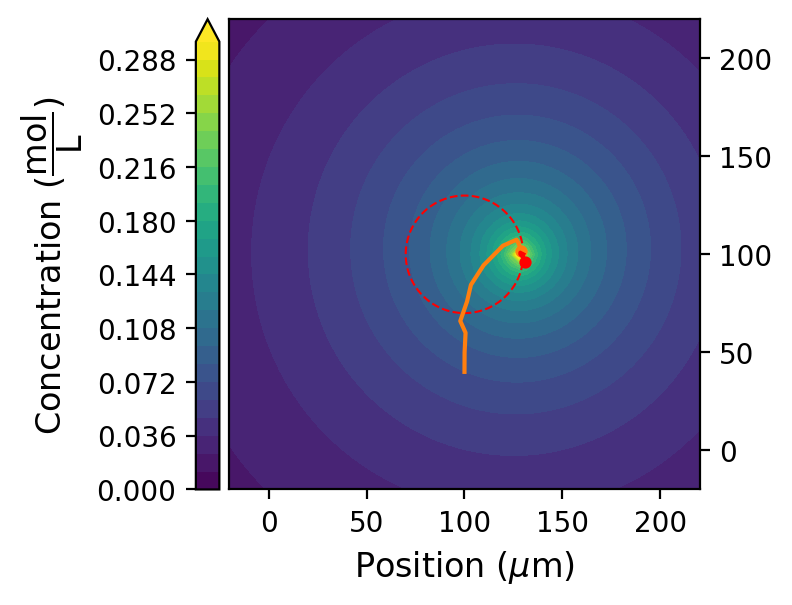

14 11
[ -3.67566662  -6.81425476  -7.07245879   5.67970937 -16.21318522
  38.90584928   6.64876328 -34.49724035   7.26411034 -35.36256888
   7.89128517 -36.21561452   8.53098941 -37.05725901   9.18354494
 -37.88776406   9.84908074 -38.70713548  10.52761618 -39.51526367
  11.21910306 -40.31198412  11.92344887 -41.0971058   12.64053049
 -41.87042518  13.37020268 -42.63173361  14.11230362 -43.38082125
  14.86665858 -44.11747927  15.6330825  -44.84150112  16.41138175
 -45.55268321  17.2013555  -46.2508254   18.00279663 -46.93573118
  18.8154925  -47.6072079   19.63922551 -48.26506682  20.47377352
 -48.90912322  21.31891024 -49.5391964   22.17440548 -50.15510976
  23.04002543 -50.75669083  23.91553285 -51.34377127  24.80068725
 -51.91618692  25.69524503 -52.47377784  26.59895963 -53.01638833
  27.51158167 -53.54386692]
[ 6.77040582e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000

KeyboardInterrupt: 

In [37]:
##run simulation and controller
xy = np.zeros((ntimes,2,nparticles))
xy[0] = pos.T
vxy = np.zeros((ntimes,2,nparticles))
##vxy[0] is zero
#uguess = np.zeros(nelectrodes*(nvision+1))
uguess = np.zeros(2*(nvision+1))
# elif mode == "chemical":
#     uguess = np.zeros(nprobes*nvision)
ustore = np.zeros((ntimes,nstakeholders))
ustoreelec = np.zeros((ntimes,nelectrodes))
grid = np.zeros((nxy,nxy))     # solution array. This is a duplicate
modelpos = xy.copy()
timer = np.zeros(len(t))

for i in range(ntimes-nvision): 
    stakehistory =  xy[:,:,:nstakeholders] #the past positions of the stakeholders. Goes into model. Needs a cutoff. 
    time0 = perf_counter()
    if i == 0: #this is sort of a janky fix to make array sizes work 
        result = least_squares(objective,uguess, bounds = bnds, args = (tsteps[:i+nvision+1],np.zeros((nstakeholders,0)), xy[i],i,mode,stakehistory[:i])) 
    elif i < ncutoffsteps: 
        result = least_squares(objective,uguess, bounds = bnds, args = (tsteps[:i+nvision+1],ustore[:i].T, xy[i],i,mode,stakehistory[:i]))
    else:
        result = least_squares(objective,uguess, bounds = bnds, args = (tsteps[i-ncutoffsteps:i+nvision+1],ustore[i-ncutoffsteps:i].T, xy[i],i,mode,stakehistory[i-ncutoffsteps:i]))
    time1 = perf_counter()
    timer[i] = time1-time0
    uresult = result.x #this gives the input divided by uemax. 
    #uresultelec = np.reshape(uresult,(nelectrodes,-1))
    uresultchem = np.ones((nstakeholders,nvision))*umax*strength #this is now in two places. Fix it.
    
    xy[i+1] = process(uresultchem[:,0],uresult[:2],grid,tlarge[i*dtratio:(i+1)*dtratio],xy[i])
    ustore[i] =  uresultchem[:,0] #maybe fixed now
    #ustoreelec[i] = uresultelec[:,0]
    #modelpos[i+1] = saveme
    plotit(i+1,xy[:,0],xy[:,1])
    if save:
        savedata(i)
    print(i, result.nfev)
    print(result.fun[:(nvision+1)*2])
    print(result.fun[(nvision+1)*2:])


Text(0, 0.5, 'Time to solve (s)')

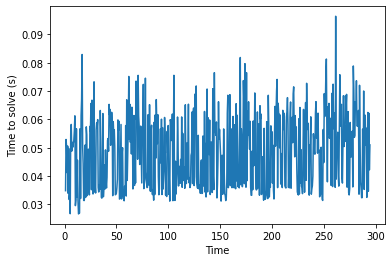

In [8]:
plt.plot(t[2:i],timer[2:i])
plt.xlabel("Time")
plt.ylabel("Time to solve (s)")
#plt.savefig("TimetosolveNobrownZero.png",bbox_inches='tight')